In [1]:
import numpy as np
import pandas as pd
import librosa
import librosa.display
import matplotlib.pyplot as plt
import tensorflow as tf
import os
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
import random

from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from IPython.display import Audio
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
from torch.utils.data import TensorDataset
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, LSTM, BatchNormalization, AveragePooling1D
from sklearn.metrics import confusion_matrix, classification_report
from pydub import AudioSegment
from keras.utils import to_categorical
from keras.callbacks import ReduceLROnPlateau
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from keras import layers

print("Libraries imported")

Libraries imported


In [2]:
TESS = "../input/toronto-emotional-speech-set-tess/tess toronto emotional speech set data/TESS Toronto emotional speech set data/"
RAV = "../input/ravdess-emotional-speech-audio/audio_speech_actors_01-24/"
CREMA = "../input/cremad/AudioWAV/"
SAVEE = "../input/surrey-audiovisual-expressed-emotion-savee/ALL/"

In [3]:
path = []
emotion = []
dir_list = os.listdir(TESS)

for i in dir_list:
    fname = os.listdir(TESS + i)   
    for f in fname:
        if i == 'OAF_angry' or i == 'YAF_angry':
            emotion.append('angry')
        elif i == 'OAF_disgust' or i == 'YAF_disgust':
            emotion.append('disgust')
        elif i == 'OAF_Fear' or i == 'YAF_fear':
            emotion.append('fear')
        elif i == 'OAF_happy' or i == 'YAF_happy':
            emotion.append('happy')
        elif i == 'OAF_neutral' or i == 'YAF_neutral':
            emotion.append('neutral')                                
        elif i == 'OAF_Pleasant_surprise' or i == 'YAF_pleasant_surprised':
            emotion.append('surprise')               
        elif i == 'OAF_Sad' or i == 'YAF_sad':
            emotion.append('sad')
        else:
            emotion.append('Unknown')
        path.append(TESS + i + "/" + f)

TESS_df = pd.DataFrame(emotion, columns = ['labels'])
TESS_df = pd.concat([TESS_df,pd.DataFrame(path, columns = ['path'])],axis=1)
print('TESS dataset loaded')

TESS dataset loaded


In [4]:
dir_list = os.listdir(SAVEE)

emotion=[]
path = []
for i in dir_list:
    if i[-8:-6]=='_a':
        emotion.append('angry')
    elif i[-8:-6]=='_d':
        emotion.append('disgust')
    elif i[-8:-6]=='_f':
        emotion.append('fear')
    elif i[-8:-6]=='_h':
        emotion.append('happy')
    elif i[-8:-6]=='_n':
        emotion.append('neutral')
    elif i[-8:-6]=='sa':
        emotion.append('sad')
    elif i[-8:-6]=='su':
        emotion.append('surprise')
    else:
        emotion.append('unknown') 
    path.append(SAVEE + i)
# ... 
SAVEE_df = pd.DataFrame(emotion, columns = ['labels'])
SAVEE_df = pd.concat([SAVEE_df, pd.DataFrame(path, columns = ['path'])], axis = 1)

print('SAVEE dataset loaded')

SAVEE dataset loaded


In [5]:
dir = os.listdir(RAV)
data = []

for actor in dir:
    files = os.listdir(RAV + actor)
    for file in files:
        part = file.split('.')[0]
        part = part.split("-")
        temp = int(part[6])

        if part[2] == '01':
            emotion = 'neutral'
        elif part[2] == '02':
            emotion = 'calm'
        elif part[2] == '03':
            emotion = 'happy'
        elif part[2] == '04':
            emotion = 'sad'
        elif part[2] == '05':
            emotion = 'angry'
        elif part[2] == '06':
            emotion = 'fear'
        elif part[2] == '07':
            emotion = 'disgust'
        elif part[2] == '08':
            emotion = 'surprise'
        else:
            emotion = 'unknown'

        path = (RAV + actor + '/' + file)
        data.append([emotion, path])

RAVDESS_df = pd.DataFrame(data)
RAVDESS_df.columns = ['labels', 'path']

print('RAVDESS dataset loaded')


RAVDESS dataset loaded


In [6]:
files = os.listdir(CREMA)
data = []

for file in files:
    part = file.split('_')
    
    if part[2] == 'SAD':
        emotion = 'sad'
    elif part[2] == 'ANG':
        emotion = 'angry'
    elif part[2] == 'DIS':
        emotion = 'disgust'
    elif part[2] == 'FEA':
        emotion = 'fear'
    elif part[2] == 'HAP':
        emotion = 'happy'
    elif part[2] == 'NEU':
        emotion = 'neutral'
    else:
        emotion = 'unknown'
    
    path = (CREMA + '/' + file)
    data.append([emotion, path])

Crema_df = pd.DataFrame(data)
Crema_df.columns = ['labels', 'path']

print('CREMA dataset loaded')

CREMA dataset loaded


In [7]:
TESS_df.head()

,labels,path
0,fear,../input/toronto-emotional-speech-set-tess/tes...
1,fear,../input/toronto-emotional-speech-set-tess/tes...
2,fear,../input/toronto-emotional-speech-set-tess/tes...
3,fear,../input/toronto-emotional-speech-set-tess/tes...
4,fear,../input/toronto-emotional-speech-set-tess/tes...


In [8]:
TESS_df.head()

,labels,path
0,fear,../input/toronto-emotional-speech-set-tess/tes...
1,fear,../input/toronto-emotional-speech-set-tess/tes...
2,fear,../input/toronto-emotional-speech-set-tess/tes...
3,fear,../input/toronto-emotional-speech-set-tess/tes...
4,fear,../input/toronto-emotional-speech-set-tess/tes...


In [9]:
RAVDESS_df.head()

,labels,path
0,surprise,../input/ravdess-emotional-speech-audio/audio_...
1,neutral,../input/ravdess-emotional-speech-audio/audio_...
2,disgust,../input/ravdess-emotional-speech-audio/audio_...
3,disgust,../input/ravdess-emotional-speech-audio/audio_...
4,neutral,../input/ravdess-emotional-speech-audio/audio_...


In [10]:
Crema_df.head()

,labels,path
0,disgust,../input/cremad/AudioWAV//1028_TSI_DIS_XX.wav
1,happy,../input/cremad/AudioWAV//1075_IEO_HAP_LO.wav
2,happy,../input/cremad/AudioWAV//1084_ITS_HAP_XX.wav
3,disgust,../input/cremad/AudioWAV//1067_IWW_DIS_XX.wav
4,disgust,../input/cremad/AudioWAV//1066_TIE_DIS_XX.wav


In [11]:
TESS_labels = TESS_df['labels'].unique()
TESS_labels.sort()

SAVEE_labels = SAVEE_df['labels'].unique()
SAVEE_labels.sort()

RAVDESS_labels = RAVDESS_df['labels'].unique()
RAVDESS_labels.sort()

Crema_labels = Crema_df['labels'].unique()
Crema_labels.sort()

print("TESS_labels: ")
print(TESS_labels)
print()
print("SAVEE_labels: ")
print()
print(SAVEE_labels)
print()
print("RAVDESS_labels: ")
print(RAVDESS_labels)
print()
print("Crema_labels: ")
print()
print(Crema_labels)
print()

TESS_labels: 
['angry' 'disgust' 'fear' 'happy' 'neutral' 'sad' 'surprise']

SAVEE_labels: 

['angry' 'disgust' 'fear' 'happy' 'neutral' 'sad' 'surprise']

RAVDESS_labels: 
['angry' 'calm' 'disgust' 'fear' 'happy' 'neutral' 'sad' 'surprise']

Crema_labels: 

['angry' 'disgust' 'fear' 'happy' 'neutral' 'sad']



TESS and SAVEE datasets, both contsist of only male audio recordings. Also, the output above shows that both TESS and SAVEE datasets have of same & equal labels/emotions

Crema-D dataset doesn't have "suprise" and "calm" labels/emotions.

TESS and SAVEE datasets doesn't have "calm" label/emotion.

In [12]:
print("Number of labels/emotions in TESS dataset : ", len(TESS_df['labels'].unique()),)
print()
print("Number of labels/emotions in SAVEE dataset : ", len(SAVEE_df['labels'].unique()),)
print()
print("Number of labels/emotions in RAVDESS dataset : ", len(RAVDESS_df['labels'].unique()),)
print()
print("Number of labels/emotions Crema-D dataset : ", len(Crema_df['labels'].unique()),)
print()

Number of labels/emotions in TESS dataset :  7

Number of labels/emotions in SAVEE dataset :  7

Number of labels/emotions in RAVDESS dataset :  8

Number of labels/emotions Crema-D dataset :  6



In summary:

TESS dataset - Consist of 7 labels/emotions for only "Male" voices.

SAVEE dataset - Consist of 7 labels/emotions for only "Male" voices.

RAVDESS dataset - Consist of 8 labels/emotions for both "Male" and "Female" voices.

Crema-D dataset - Consist of 6 labels/emotions for both "Male" and "Female" voices.

In [13]:
TESS_df['labels'].value_counts()

labels
fear        400
angry       400
disgust     400
neutral     400
sad         400
surprise    400
happy       400
Name: count, dtype: int64

In [14]:
label_counts = TESS_df['labels'].value_counts()
TESS_total_audio_recordings = label_counts.sum()
print("Total Number of Audio Recordings in TESS_df:", TESS_total_audio_recordings)

Total Number of Audio Recordings in TESS_df: 2800


In [15]:
SAVEE_df['labels'].value_counts()

labels
neutral     120
happy        60
fear         60
disgust      60
angry        60
surprise     60
sad          60
Name: count, dtype: int64

In [16]:
label_counts = SAVEE_df['labels'].value_counts()
SAVEE_total_audio_recordings = label_counts.sum()
print("Total Number of Audio Recordings in SAVEE_df:", SAVEE_total_audio_recordings)

Total Number of Audio Recordings in SAVEE_df: 480


In [17]:
RAVDESS_df['labels'].value_counts()

labels
surprise    192
disgust     192
fear        192
sad         192
calm        192
happy       192
angry       192
neutral      96
Name: count, dtype: int64

In [18]:
label_counts = RAVDESS_df['labels'].value_counts()
RAVDESS_total_audio_recordings = label_counts.sum()
print("Total Number of Audio Recordings in RAVDESS_df:", RAVDESS_total_audio_recordings)

Total Number of Audio Recordings in RAVDESS_df: 1440


In [19]:
Crema_df['labels'].value_counts()

labels
disgust    1271
happy      1271
sad        1271
fear       1271
angry      1271
neutral    1087
Name: count, dtype: int64

In [20]:
label_counts = Crema_df['labels'].value_counts()
Crema_total_audio_recordings = label_counts.sum()
print("Total Number of Audio Recordings in Crema_df:", Crema_total_audio_recordings)

Total Number of Audio Recordings in Crema_df: 7442


In [21]:
# Merge all datasets into one unified dataset
combined_df = pd.concat([TESS_df, SAVEE_df, RAVDESS_df, Crema_df], ignore_index=True)

print('All datasets loaded')

All datasets loaded


In [22]:
combined_df.head()

,labels,path
0,fear,../input/toronto-emotional-speech-set-tess/tes...
1,fear,../input/toronto-emotional-speech-set-tess/tes...
2,fear,../input/toronto-emotional-speech-set-tess/tes...
3,fear,../input/toronto-emotional-speech-set-tess/tes...
4,fear,../input/toronto-emotional-speech-set-tess/tes...


In [23]:
combined_df['labels'].value_counts()

labels
fear        1923
angry       1923
disgust     1923
sad         1923
happy       1923
neutral     1703
surprise     652
calm         192
Name: count, dtype: int64

In [24]:
unique_labels = combined_df['labels'].unique()
print("Unique Labels in the Combined Dataset:")
for label in unique_labels:
    print(label)

Unique Labels in the Combined Dataset:
fear
angry
disgust
neutral
sad
surprise
happy
calm


In [25]:
print("Number of labels/emotions Combined dataset : ", len(combined_df['labels'].unique()),)

Number of labels/emotions Combined dataset :  8


In [26]:
label_counts = combined_df['labels'].value_counts()
combined_total_audio_recordings = label_counts.sum()
print("Total Number of Audio Recordings in combine_df:", combined_total_audio_recordings)

Total Number of Audio Recordings in combine_df: 12162


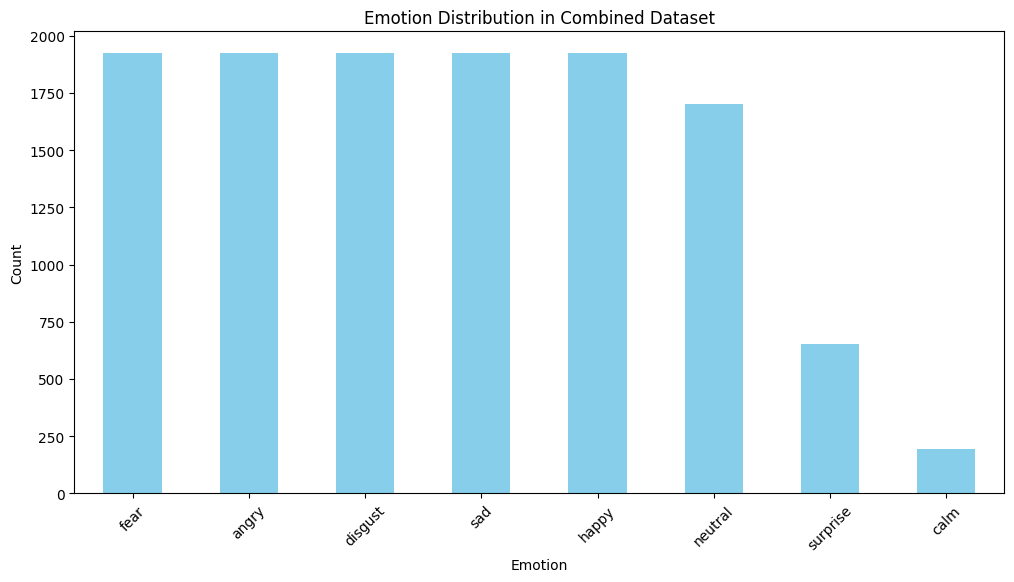

In [27]:
plt.figure(figsize=(12, 6))
label_counts.plot(kind='bar', color='skyblue')
plt.title('Emotion Distribution in Combined Dataset')
plt.xlabel('Emotion')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

In [28]:
def create_waveplot(data, sr, e):
    plt.figure(figsize=(10, 3))
    plt.title('Waveplot for audio with {} emotion'.format(e), size=15)
    librosa.display.waveshow(data, sr=sr)
    plt.show()

def create_spectrogram(data, sr, e):
    # stft function converts the data into short term fourier transform
    X = librosa.stft(data)
    Xdb = librosa.amplitude_to_db(abs(X))
    plt.figure(figsize=(12, 3))
    plt.title('Spectrogram for audio with {} emotion'.format(e), size=15)
    librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')   
    plt.colorbar()

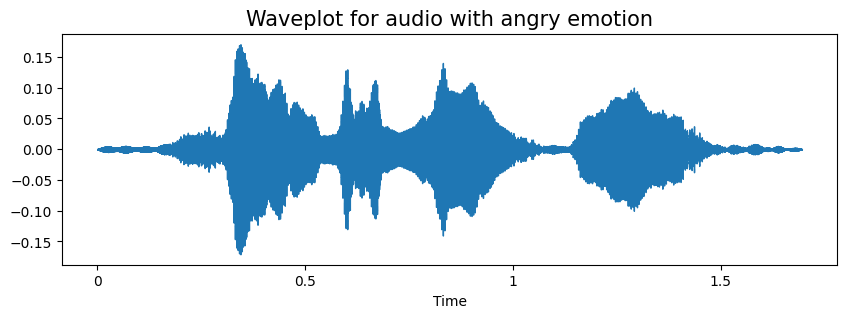

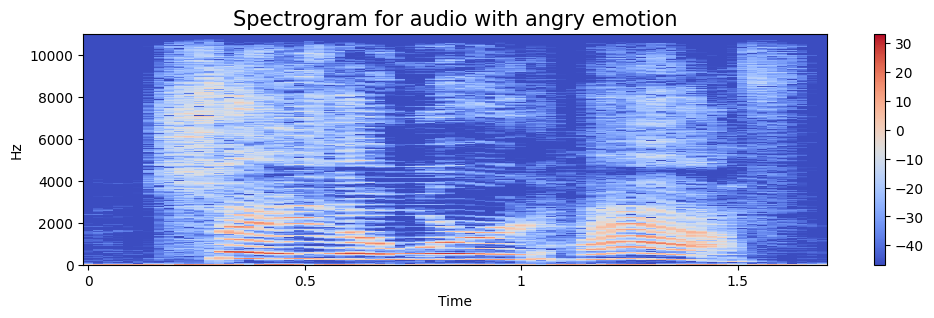

In [29]:
emotion='angry'
path = np.array(combined_df.path[combined_df.labels==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

In [30]:
#total_duration = 0

#for audio_file_path in combined_df['path']:
    #y, sr = librosa.load(audio_file_path, sr=None, res_type='kaiser_fast')
    
    #duration = librosa.get_duration(y=y, sr=sr)
    
    #total_duration += duration

#hours = int(total_duration // 3600)
#minutes = int((total_duration % 3600) // 60)
#seconds = int(total_duration % 60)

#print(f"Total duration of all audio files: {total_duration:.2f} seconds")

#print(f"Total duration of all audio files: {hours}h {minutes}m {seconds}s")

In [31]:
def noise(data):
    noise_amp = 0.02*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data

def stretch(data, rate=0.90):
    return librosa.effects.time_stretch(data,rate=rate)

def shift(data):
    shift_range = int(np.random.uniform(low=-2, high = 2)*1000)
    return np.roll(data, shift_range)

def pitch(data, sampling_rate, pitch_factor=0.5):
    return librosa.effects.pitch_shift(data, sr=sampling_rate, n_steps=pitch_factor)

def higher_speed(data, speed_factor = 1.10):
    return librosa.effects.time_stretch(data,rate=speed_factor)

def lower_speed(data, speed_factor = 0.90):
    return librosa.effects.time_stretch(data,rate=speed_factor)

In [32]:
def _plot_signal_and_augmented_signal(signal, augmented_signal, sr):
    fig, ax = plt.subplots(nrows=2)
    librosa.display.waveshow(signal, sr=sr, ax=ax[0])
    ax[0].set(title='Original Signal')
    librosa.display.waveshow(augmented_signal, sr=sr, ax=ax[1])
    ax[1].set(title='Augmented Signal')
    plt.show()

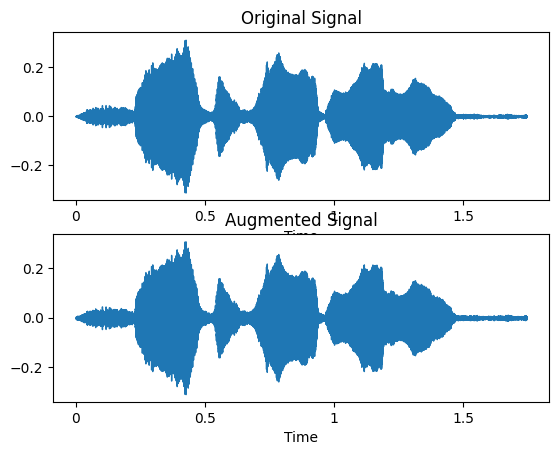

In [33]:
path = np.array(combined_df.path)[1]
data, sr = librosa.load(path)
augmented_signal = noise(data)
_plot_signal_and_augmented_signal(data, augmented_signal, sr)

In [34]:
def extract_features(data):
    
    result = np.array([])
    
    mfccs = librosa.feature.mfcc(y=data, sr=22050, n_mfcc=58)
    mfccs_processed = np.mean(mfccs.T,axis=0)
    result = np.array(mfccs_processed)
     
    return result

def get_features(path):
    # duration and offset are used to take care of the no audio in start and the ending of each audio files as seen above.
    data, sample_rate = librosa.load(path, duration=3, offset=0.5) 
    
    # without augmentation
    res1 = extract_features(data)
    result = np.array(res1)
    
    # noised
    noise_data = noise(data)
    res2 = extract_features(noise_data)
    result = np.vstack((result, res2))  # stacking vertically
    
    # stretched
    stretch_data = stretch(data)
    res3 = extract_features(stretch_data)
    result = np.vstack((result, res3))
    
    # shifted
    shift_data = shift(data)
    res4 = extract_features(shift_data)
    result = np.vstack((result, res4))
    
    # pitched
    pitch_data = pitch(data, sample_rate)
    res5 = extract_features(pitch_data)
    result = np.vstack((result, res5)) 
    
    # speed up
    higher_speed_data = higher_speed(data)
    res6 = extract_features(higher_speed_data)
    result = np.vstack((result, res6))
    
    # speed down
    lower_speed_data = lower_speed(data)  # Corrected function call to lower_speed
    res7 = extract_features(lower_speed_data)
    result = np.vstack((result, res7))
    
    return result


In [35]:
X, Y = [], []

for path, emotion in zip(combined_df.path, combined_df.labels):
    features = get_features(path)
    for feature in features:
        X.append(feature)
        # appending emotion 5 times as we have made 5 augmentation techniques on each audio file.
        Y.append(emotion)

In [36]:
#subset_size = 1000  

#combined_subset = combined_df.sample(n=subset_size, random_state=42)  

#X_subset, Y_subset = [], []

#for path, emotion in zip(combined_subset.path, combined_subset.labels):
    #features = get_features(path)
    #for feature in features:
        #X_subset.append(feature)
        #Y_subset.append(emotion)

In [37]:
#print("Length of combined_df:", len(combined_df))
#print(combined_df.head())

In [38]:
len(X), len(Y), combined_df.path.shape

(85134, 85134, (12162,))

In [39]:
Features = pd.DataFrame(X)
Features['labels'] = Y
Features.to_csv('New_Features.csv', index=False)
print(len(Features))
Features.head()

85134


,0,1,2,3,4,5,6,7,8,9,...,49,50,51,52,53,54,55,56,57,labels
0,-285.737274,85.782951,-2.168911,22.125532,-14.757395,11.051346,12.412449,-3.000262,1.084499,11.078272,...,0.947927,2.542854,-2.743385,-8.565829,-0.940562,0.440848,0.247026,4.961292,1.831468,fear
1,-234.847185,60.374335,3.607897,13.731632,-5.799912,5.457431,11.259155,-2.643345,1.416588,4.931299,...,-1.503504,0.762920,-2.115331,-6.426622,-2.182153,0.771204,0.805402,3.029102,2.248663,fear
2,-309.988403,88.779900,-4.047421,23.122707,-12.072708,13.171967,14.262882,-1.791964,2.977596,11.293369,...,0.231993,2.831644,-2.533443,-8.192330,-1.135127,0.203005,0.812251,5.109948,1.957834,fear
3,-282.719025,87.383377,-1.377929,22.663372,-14.648235,10.501597,11.907259,-3.227560,0.894022,10.777364,...,0.802242,2.599139,-2.528267,-8.302024,-0.702310,0.313455,0.004866,4.854069,1.933526,fear
4,-301.108582,85.974098,-2.350865,22.687103,-12.367916,14.081511,13.014625,-2.947807,5.070571,7.732955,...,4.460817,-3.163811,-7.867892,-3.986179,5.249454,-0.431891,5.024064,2.161206,-0.616961,fear


In [40]:
X_subset = Features.iloc[: ,:-1].values
Y_subset = Features['labels'].values

In [41]:
encoder = OneHotEncoder()
Y_subset_res = encoder.fit_transform(np.array(Y_subset).reshape(-1,1)).toarray()

In [42]:
x_train, x_test, y_train, y_test = train_test_split(X_subset, Y_subset_res,test_size = 0.2, random_state=42, shuffle=True)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((68107, 58), (68107, 8), (17027, 58), (17027, 8))

In [43]:
# making our data compatible to model.
x_train = np.expand_dims(x_train, axis=2)
x_test = np.expand_dims(x_test, axis=2)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((68107, 58, 1), (68107, 8), (17027, 58, 1), (17027, 8))

# Modeling

In [44]:
model = Sequential()

model.add(layers.Conv1D(512, kernel_size=5, strides=1, padding="same", activation="relu", input_shape=(x_train.shape[1], 1)))
model.add(layers.BatchNormalization())
model.add(layers.MaxPool1D(pool_size=5, strides=2, padding="same"))

model.add(layers.Conv1D(512, kernel_size=5, strides=1, padding="same", activation="relu"))
model.add(layers.BatchNormalization())
model.add(layers.MaxPool1D(pool_size=5, strides=2, padding="same"))

model.add(layers.Conv1D(256, kernel_size=5, strides=1, padding="same", activation="relu"))
model.add(layers.BatchNormalization())
model.add(layers.MaxPool1D(pool_size=5, strides=2, padding="same"))

model.add(layers.Conv1D(256, kernel_size=3, strides=1, padding='same', activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling1D(pool_size=5, strides=2, padding='same'))

model.add(layers.Conv1D(128, kernel_size=3, strides=1, padding='same', activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling1D(pool_size=3, strides=2, padding='same'))

model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.BatchNormalization())

# Modified layer to have 12 neurons to match the number of classes this data
model.add(layers.Dense(8, activation="softmax"))

model.compile(optimizer='RMSprop', loss='categorical_crossentropy', metrics=['accuracy'])

In [45]:
rlrp = ReduceLROnPlateau(monitor='val_accuracy', patience=3, verbose=1, factor=0.5, min_lr=0.00001)
earlystopping = EarlyStopping(monitor="val_accuracy", mode='auto', patience=5, restore_best_weights=True)

history = model.fit(x_train, y_train, batch_size=64, epochs=50, validation_data=(x_test, y_test), callbacks=[rlrp, earlystopping])

Epoch 1/50
1065/1065 [==============================] - 443s 413ms/step - loss: 1.2869 - accuracy: 0.4993 - val_loss: 1.5942 - val_accuracy: 0.4867 - lr: 0.0010
Epoch 2/50
1065/1065 [==============================] - 433s 406ms/step - loss: 1.0737 - accuracy: 0.5758 - val_loss: 1.2131 - val_accuracy: 0.5222 - lr: 0.0010
Epoch 3/50
1065/1065 [==============================] - 433s 407ms/step - loss: 0.9864 - accuracy: 0.6138 - val_loss: 1.5074 - val_accuracy: 0.4920 - lr: 0.0010
Epoch 4/50
1065/1065 [==============================] - 435s 408ms/step - loss: 0.9031 - accuracy: 0.6494 - val_loss: 0.9909 - val_accuracy: 0.6230 - lr: 0.0010
Epoch 5/50
1065/1065 [==============================] - 433s 407ms/step - loss: 0.8158 - accuracy: 0.6858 - val_loss: 1.2392 - val_accuracy: 0.5865 - lr: 0.0010
Epoch 6/50
1065/1065 [==============================] - 433s 407ms/step - loss: 0.7274 - accuracy: 0.7232 - val_loss: 1.0384 - val_accuracy: 0.6457 - lr: 0.0010
Epoch 7/50
1065/1065 [============

In [46]:
# Train the model
#history = model.fit(x_train, y_train, batch_size=64, epochs=50, validation_data=(x_test, y_test))

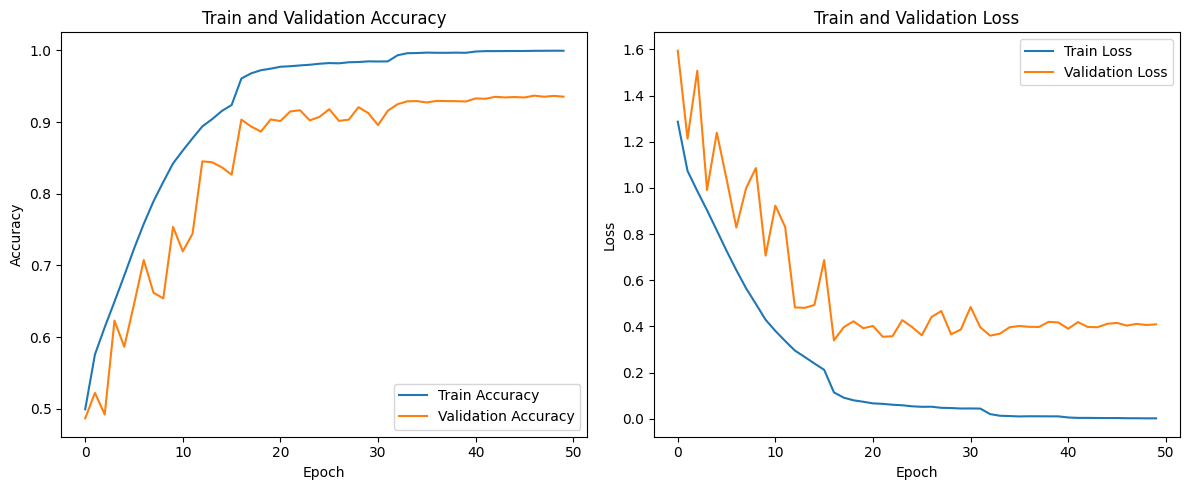

In [47]:
plt.figure(figsize=(12, 5))

# Plot Training and Validation Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Train and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot Training and Validation Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Train and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout() 
plt.show()


533/533 [==============================] - 19s 35ms/step


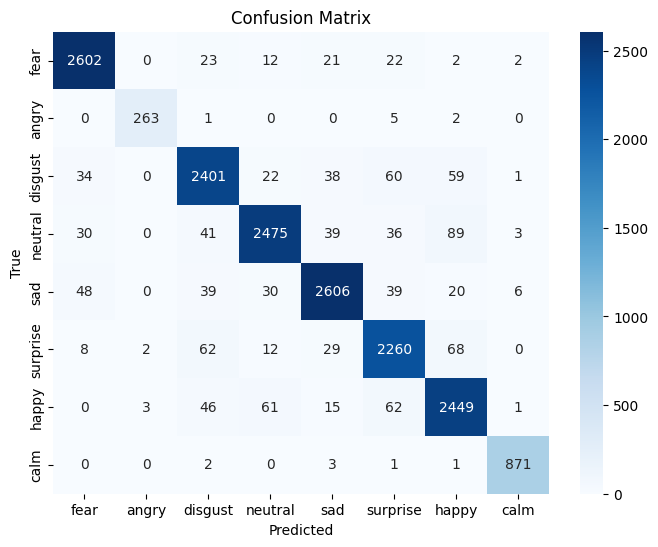

In [48]:
# Predict labels for the test set
y_pred = model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

# Calculate confusion matrix
confusion_mtx = confusion_matrix(y_true, y_pred_classes)

# Display the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_mtx, annot=True, fmt='d', cmap='Blues',
            xticklabels= combined_df['labels'].unique(),
            yticklabels= combined_df['labels'].unique())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [49]:
#combined_df['labels'].unique()

In [50]:
# Generate a classification report
report = classification_report(y_true, y_pred_classes, target_names=combined_df['labels'].unique())
print(report)

              precision    recall  f1-score   support

        fear       0.96      0.97      0.96      2684
       angry       0.98      0.97      0.98       271
     disgust       0.92      0.92      0.92      2615
     neutral       0.95      0.91      0.93      2713
         sad       0.95      0.93      0.94      2788
    surprise       0.91      0.93      0.92      2441
       happy       0.91      0.93      0.92      2637
        calm       0.99      0.99      0.99       878

    accuracy                           0.94     17027
   macro avg       0.94      0.94      0.94     17027
weighted avg       0.94      0.94      0.94     17027



In [51]:
# Save the entire model to a HDF5 file
model.save("entire_trained-model.h5")

## Precision: 
95% of the instances that the model predicted as 'fear' were correct.

## Recall:

Measures the percentage of actual positives that were correctly identified.

'disgust' has a recall of 85%, which means that the model correctly identified 85% of the actual 'disgust' instances.

## F1-Score:

The harmonic mean of precision and recall. It considers both false positives and false negatives. For instance:

'neutral' has an F1-Score of 0.92, which is a balance between precision and recall for 'neutral'

## Support:

The number of actual occurrences of the class in the dataset. For instance:

There are 210 instances of 'fear' and 27 instances of 'angry'.

## Macro Average and Weighted Average: 

These are the averages of the metrics for individual classes, calculated either by treating each class equally (macro) or taking a weighted average based on the number of instances in each class (weighted).